In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('gamma.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
print(df.shape)

(19020, 11)


In [5]:
df[10].value_counts()

g    12332
h     6688
Name: 10, dtype: int64

In [5]:
data_x = df.iloc[:, :-1]
data_y = df.iloc[:, -1]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Random Train/Test Split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                    test_size=0.30, 
                                                    shuffle=True,
                                                    random_state=42)

# Normalization of features
min_max_scaler = MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
test_x = min_max_scaler.transform(test_x)

# Create DataFrame from Numpy array
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)

# Prevents issues with CV
train_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

In [7]:
print(train_y.value_counts())
print(test_y.value_counts())

g    8627
h    4687
Name: 10, dtype: int64
g    3705
h    2001
Name: 10, dtype: int64


### Cross Validation
- Notes on the dataset:
    - g = gamma (signal): 12332       = 0 (negative class)
    - h = hadron (background): 6688   = 1 (positive class)

#### LEARNING CURVES

In [27]:
'''LEARNING CURVE!!!'''
'''Stratified Shuffle K-fold CV, AT DIFFERENT SAMPLE SIZES'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For storing statistics for future plots
fold_train_scores = []
fold_val_scores = []
number_samples_list = []

'''MODEL BUILD HERE'''
# DecisionTreeClassifier(criterion='entropy', max_depth=5)
# AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3), n_estimators=12) 
# MLPClassifier(hidden_layer_sizes=(10,10), max_iter=60, learning_rate_init=0.025)
# SVC(kernel='rbf', gamma=2.0)
# KNeighborsClassifier(n_neighbors=3)
model = KNeighborsClassifier(n_neighbors=3)

for i in [2, 3, 4, 5, 6, 8, 10, 12, 14, 50, 100]:
    '''
    Loop through a set of folds of CV
    Collect success metrics for each CV run
    Plot # of folds/# of samples vs success metric
    '''
    
    # Get splits of CV
    folds = i
    number_samples = int(train_x.shape[0] - (train_x.shape[0]/folds))
    sss = StratifiedKFold(folds)

    # Store Scoring Metric
    train_scores = []
    val_scores = []

    print('# of samples:', number_samples)
    for train_index, val_index in sss.split(train_x, train_y):

        # Train and validation sets
        partial_train_x, val_x = train_x.iloc[train_index, :], train_x.iloc[val_index, :]
        partial_train_y, val_y = train_y[train_index], train_y[val_index]

        # Build and Train Model
        clf = model         
        clf.fit(partial_train_x, partial_train_y)

        # Collect success metrics
        train_score = clf.score(partial_train_x, partial_train_y)
        train_scores.append(train_score)

        val_score = clf.score(val_x, val_y)
        val_scores.append(val_score)


    # Get average scores from CV
    avg_train = np.average(train_scores)
    avg_val = np.average(val_scores)

    # Append to final score lists
    fold_train_scores.append(avg_train)
    fold_val_scores.append(avg_val)
    number_samples_list.append(number_samples)
    
# Reverse CV where training is the fold left out and test is all the other folds
for i in [2, 3, 4, 5, 6, 7, 9, 11, 13, 50, 100, 500]:
    '''
    Loop through a set of folds of CV
    Collect success metrics for each CV run
    Plot # of folds/# of samples vs success metric
    '''
    
    # Get splits of CV
    folds = i
    number_samples = int(train_x.shape[0]/folds)
    sss = StratifiedKFold(folds)

    # Store Scoring Metric
    train_scores = []
    val_scores = []

    print('# of samples:', number_samples)
    for train_index, val_index in sss.split(train_x, train_y):

        # Train and validation sets
        partial_train_x, val_x = train_x.iloc[val_index, :], train_x.iloc[train_index, :]
        partial_train_y, val_y = train_y[val_index], train_y[train_index]

        # Build and Train Model
        clf = model
        clf.fit(partial_train_x, partial_train_y)

        # Collect success metrics
        train_score = clf.score(partial_train_x, partial_train_y)
        train_scores.append(train_score)

        val_score = clf.score(val_x, val_y)
        val_scores.append(val_score)


    # Get average scores from CV
    avg_train = np.average(train_scores)
    avg_val = np.average(val_scores)

    # Append to final score lists
    fold_train_scores.append(avg_train)
    fold_val_scores.append(avg_val)
    number_samples_list.append(number_samples)

# of samples: 6657
# of samples: 8876
# of samples: 9985
# of samples: 10651
# of samples: 11095
# of samples: 11649
# of samples: 11982
# of samples: 12204
# of samples: 12363
# of samples: 13047
# of samples: 13180
# of samples: 6657
# of samples: 4438
# of samples: 3328
# of samples: 2662
# of samples: 2219
# of samples: 1902
# of samples: 1479
# of samples: 1210
# of samples: 1024
# of samples: 266
# of samples: 133
# of samples: 26


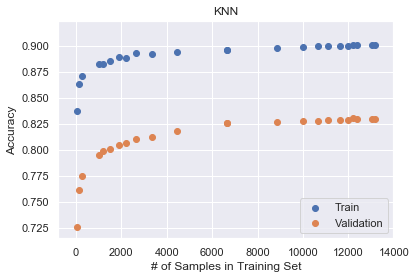

In [28]:
'''# of Samples vs Accuracy Rate'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of Samples in Training Set'
ylabel = 'Accuracy'
title = 'KNN'
dataset = 'MAGIC'

sns.set()
plt.scatter(x=number_samples_list, y=fold_train_scores, label='Train')
plt.scatter(x=number_samples_list, y=fold_val_scores, label='Validation')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend()

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + ".png")

plt.show()

#### MODEL COMPLEXITY

In [25]:
'''MODEL COMPLEXITY CURVE'''
'''Stratified Shuffle K-fold CV'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For storing statistics for future plots
hyperparameter_train_scores = []
hyperparameter_val_scores = []
hyperparameter_list = []


# range(1, 30, 1)
# range(1, 50, 1)
# range(10, 300, 25)
# [0.001, 0.005, 0.01, 0.025, 0.05, 0.10, 0.20]
# ['linear', 'poly', 'rbf', 'sigmoid']
# [0.05, 0.10, 0.25, 0.50, 1.0, 1.5, 2.0, 3.0]
# range(1, 10, 1)

for i in range(1, 10, 1):                        
    '''
    Loop through a range of values for a particular hyperparameter
    Collect success metric for each discrete hyperparameter value
        - Must determine at what number of CV folds to choose
    Plot the hyperparameters vs the success metric
    '''
    print(i)
    
    '''MODEL BUILD HERE'''
    # DecisionTreeClassifier(criterion='entropy', max_depth=i)
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3), n_estimators=i) 
    # MLPClassifier(hidden_layer_sizes=(10,10), max_iter=60, learning_rate_init=i)
    # SVC(kernel=i, degree=2)
    # KNeighborsClassifier(n_neighbors=i)
    clf = KNeighborsClassifier(n_neighbors=i)
    
    # Get splits of CV
    folds = 2                                   # CHANGE # of FOLDS HERE
    sss = StratifiedKFold(folds)

    # Store Scoring Metric
    train_scores = []
    val_scores = []

    for train_index, val_index in sss.split(train_x, train_y):

        # Train and validation sets
        partial_train_x, val_x = train_x.iloc[train_index, :], train_x.iloc[val_index, :]
        partial_train_y, val_y = train_y[train_index], train_y[val_index]

        # Build and Train Model          
        clf.fit(partial_train_x, partial_train_y)

        # Collect success metrics
        train_score = clf.score(partial_train_x, partial_train_y)
        train_scores.append(train_score)

        val_score = clf.score(val_x, val_y)
        val_scores.append(val_score)


    # Get average scores from CV
    avg_train = np.average(train_scores)
    avg_val = np.average(val_scores)

    # Append to final score lists
    hyperparameter_train_scores.append(avg_train)
    hyperparameter_val_scores.append(avg_val)
    hyperparameter_list.append(i)

1
2
3
4
5
6
7
8
9


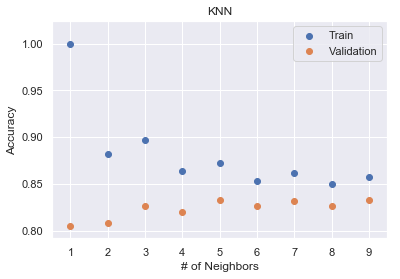

In [26]:
'''hyperparameter vs Accuracy Rate'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of Neighbors'
ylabel = 'Accuracy'
title = 'KNN'
dataset = 'MAGIC'

sns.set()

# # ONLY FOR SVM KERNEL COMPARISON PLOTS
# plt.bar(x=hyperparameter_list, height=hyperparameter_train_scores,
#         width=-0.3, align='edge', label='Train')
# plt.bar(x=hyperparameter_list, height=hyperparameter_val_scores,
#         width=0.3, align='edge', label='Validation')

plt.scatter(x=hyperparameter_list, y=hyperparameter_train_scores, label='Train')
plt.scatter(x=hyperparameter_list, y=hyperparameter_val_scores, label='Validation')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)

plt.legend()

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + ".png")

plt.show()

#### TIME COMPLEXITY

In [42]:
'''TIME COMPLEXITY CURVE'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

# For storing statistics for future plots
iteration_count = []
time_elapsed = []

for i in range(10, 300, 10):                        
    '''
    Loop through a range of values for a iterations
    Collect time it takes per iteration
    Plot the iteration vs time
    '''
    print(i)
    iteration_count.append(i)
    
    '''MODEL BUILD HERE'''
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=i)
    # MLPClassifier(hidden_layer_sizes=(10, 10), learning_rate_init=0.025, max_iter=i)
    # SVC(kernel='rbf', gamma=2.0, max_iter=i)
    clf = SVC(kernel='rbf', gamma=2.0, max_iter=i)
    
    # START TIME
    start = time.time()
    
    # Train on full dataset
    clf.fit(train_x, train_y)
    
    # END TIME
    end = time.time()
    time_elapsed.append(end - start)

10
20
30
40
50


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=30).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_it

60
70
80


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=60).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=70).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=80).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


90
100
110


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=90).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=110).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


120
130


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=120).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=130).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


140
150


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=140).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


160
170


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=160).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=170).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


180
190


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=180).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=190).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


200
210


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=210).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


220
230


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=220).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=230).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


240
250


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=240).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


260


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=260).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


270


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=270).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


280


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=280).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


290


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=290).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


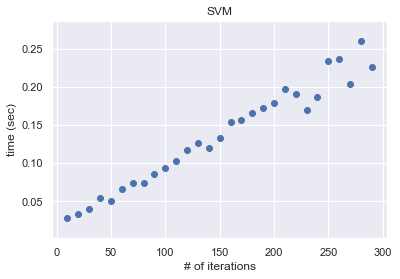

In [43]:
'''NUMBER OF ITERATIONS VS TIME'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of iterations'
ylabel = 'time (sec)'
title = 'SVM'
dataset = 'MAGIC'

sns.set()

plt.scatter(x=iteration_count, y=time_elapsed)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + "_time.png")

plt.show()

In [64]:
'''TIME COMPLEXITY CURVES WITH VARYING SAMPLE SIZE'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

# For storing statistics for future plots
train_sample_size = []
val_sample_size = []
train_time_elapsed = []
val_time_elapsed = []

for i in [i * 0.1 for i in range(1, 10)]:                        
    '''
    Loop through a range of sample sizes
    Calculate start and end times for test and training sets
    Plot the sample size vs time
    '''
    print(i)
    train_size = int(len(train_x) * i)
    train_sample_size.append(train_size)
    
    # Create train/validation sets
    partial_train_x = train_x[:train_size]
    partial_train_y = train_y[:train_size]
    val_x = train_x[train_size:]
    val_y = train_y[train_size:]
    
    val_sample_size.append(len(val_y))
    
    '''MODEL BUILD HERE'''
    # DecisionTreeClassifier(criterion='entropy', max_depth=5)
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3), n_estimators=12) 
    # MLPClassifier(hidden_layer_sizes=(10,10), max_iter=60, learning_rate_init=0.025)
    # SVC(kernel='rbf', gamma=2.0)
    # KNeighborsClassifier(n_neighbors=3)
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
    
    # TRAINING
    # START TIME
    start_train = time.time()
    
    # Train on full dataset
    clf.fit(train_x, train_y)
    
    # END TIME
    end_train = time.time()
    train_time_elapsed.append(end_train - start_train)
    
    # VALIDATION
    # START TIME
    start_val = time.time()
    
    # Train on full dataset
    clf.predict(val_x)
    
    # END TIME
    end_val = time.time()
    val_time_elapsed.append(end_val - start_val)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


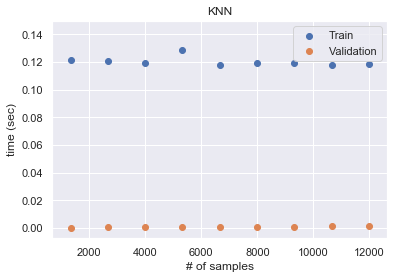

In [65]:
'''SAMPLE SIZE VS TIME'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of samples'
ylabel = 'time (sec)'
title = 'KNN'
dataset = 'MAGIC'

sns.set()

plt.scatter(x=train_sample_size, y=train_time_elapsed, label='Train')
plt.scatter(x=val_sample_size, y=val_time_elapsed, label='Validation')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend()

# # Saving plots
# plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + "_time.png")

plt.show()

## FINAL MODEL BUILDS

In [30]:
# Scorers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

#### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Build Architecture
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.8269492076478269
Test Accuracy: 0.8193130038555906


array([[3271,  434],
       [ 597, 1404]])

#### AdaBoost

In [32]:
from sklearn.ensemble import AdaBoostClassifier

# Build Architecture
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3), 
                         n_estimators=12)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.8481293334580147
Test Accuracy: 0.8571678934454959


array([[3434,  271],
       [ 544, 1457]])

#### Multi-Layer Perceptron (MLP)

In [34]:
from sklearn.neural_network import MLPClassifier

# Build Architecture
clf = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=60, 
                    learning_rate_init=0.025)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.8415198848045728
Test Accuracy: 0.852260778128286


array([[3560,  145],
       [ 698, 1303]])

#### SVM
- Kernel: rbf, linear, poly, sigmoid

In [35]:
from sklearn.svm import SVC

# Build Architecture
clf = SVC(kernel='rbf', gamma=2.0)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.8554150894961527
Test Accuracy: 0.858745180511742


array([[3534,  171],
       [ 635, 1366]])

#### KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

# Build Architecture
clf = KNeighborsClassifier(n_neighbors=3)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.826197689809252
Test Accuracy: 0.8261479144759902


array([[3390,  315],
       [ 677, 1324]])